## Train model

#### Import data

In [9]:
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

cifar_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#### Accessing the trained ML model provided

To simplify the interaction we have made available a tensorflow Resnet32 model trained with the CIFAR10 dataset.

We'll be able to access this through the file provided in this public google bucket: `gs://seldon-models/tfserving/cifar10/resnet32`.

We can copy it locally with the following command:

In [6]:
!gsutil cp -r gs://seldon-models/tfserving/cifar10/resnet32 .

Copying gs://seldon-models/tfserving/cifar10/resnet32/1/saved_model.pb...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.data-00000-of-00002...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.data-00001-of-00002...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.index...
\ [4 files][  7.2 MiB/  7.2 MiB]                                                
Operation completed over 4 objects/7.2 MiB.                                      


#### (Optional) Training the model yourself

The Alibi project provides a set of helpers that we can use to train the model. 

This uses the resnet32 model so it will take quite a few minutes even on a GPU.

If you still want to train it yourself you can run the command below, alternatively we provide an uploaded model which we'll use.

In [191]:
!git clone https://github.com/SeldonIO/alibi-detect --branch v0.4.3

!mkdir -p resnet32

!python alibi-detect/alibi_detect/models/resnet.py --serving True --model_dir ./resnet32

RandomForestClassifier(n_estimators=50)

This trains and exports our model in to the ./model/ folder. 

We can then upload this folder as it is into a google bucket.

If you follow this step, you will be able to use your own bucket instead of the one we provide.

In [3]:
!gsutil cp -r ./model/ <yourbuckethere>

/bin/sh: 1: Syntax error: end of file unexpected


#### Test Model Locally

Once you follow one of the methods above, you are able to test the model locally.

For this we have to load it with Tensorflow and then run a data instance through it.

In [10]:
model = tf.saved_model.load("resnet32/1/")

In [11]:
X_curr = X_train[1:2]

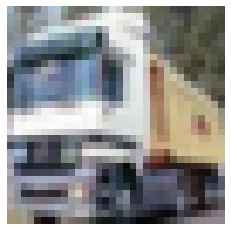

In [12]:
plt.imshow(X_curr[0])
plt.axis('off')
plt.show()

In [13]:
X_curr_pred = model(X_curr)
X_curr_pred.numpy()

array([[1.2644829e-06, 4.8814401e-09, 1.5153264e-09, 8.4905425e-09,
        5.5130661e-10, 1.1617126e-09, 5.7728627e-10, 2.8839472e-07,
        6.1489339e-04, 9.9938357e-01]], dtype=float32)

Prediction result based on model:

In [14]:
cifar_classes[np.argmax(X_curr_pred)]

'truck'

## Deploy model

In [85]:
%%bash
kubectl apply -f - << END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
      logger:
        url: http://default-broker.seldon-logs.svc.cluster.local:80/
        mode: all
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/cifar10 configured


In [2]:
!kubectl get pods | grep cifar

cifar10-default-0-cifar10-c44c88989-dxmrc                         2/2     Running   0          47s


In [17]:
import requests

In [89]:
pred = requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", json={ "instances": X_curr.tolist() })
pred.json()

{'predictions': [[1.26448288e-06,
   4.88144e-09,
   1.51532642e-09,
   8.49054249e-09,
   5.51306611e-10,
   1.16171261e-09,
   5.77286274e-10,
   2.88394716e-07,
   0.00061489339,
   0.999383569]]}

In [88]:
cifar_classes[np.argmax(pred.json()["predictions"][0])]

'truck'

### Send requests to visualise system performance

In [197]:
import time

while True:
    for x in X:
        pred_req = {"data":{"ndarray":[x.tolist()]}}

        pred_resp = requests.post(f"{url}/predictions", json=pred_req)

        time.sleep(0.1)

KeyboardInterrupt: 

### To send feedback first send requests and capture id

In [198]:
import time

puids = []

for x in X:
    pred_req = {"data":{"ndarray":[x.tolist()]}}
    pred_resp = requests.post(f"{url}/predictions", json=pred_req)
    
    puid_seldon = pred_resp.headers.get("seldon-puid")
    puids.append(puid_seldon)
    time.sleep(0.1)

#### Send feedback to visualise statistical performance (actual)

In [161]:
y_one_hot = np.eye(Y.max() + 1)[Y] # Covert to one hot
for puid, y in zip(puids, y_one_hot):
    data = {
        "truth": {
            'data': {
                'names': ['t:0', 't:1', 't:2'], 
                'ndarray': [y.tolist()]
            }
        }
    }
    requests.post(f"{url}/feedback", json=data, headers={"seldon-puid": puid})
    time.sleep(0.5)

#### Send feedback to visualise statistical performance (Skewed)

In [200]:
y_one_hot = np.eye(Y.max() + 1)[Y] # Covert to one hot
y_rand = np.array(y_one_hot)
np.random.shuffle(y_rand)
while True:
    for puid, y in zip(puids, y_rand):
        data = {
            "truth": {
                'data': {
                    'names': ['t:0', 't:1', 't:2'], 
                    'ndarray': [y.tolist()]
                }
            }
        }
        requests.post(f"{url}/feedback", json=data, headers={"seldon-puid": puid})
        time.sleep(0.1)

KeyboardInterrupt: 

### Explainer
Now we can train and deploy an explainer.

#### Train explainer

In [201]:
predict_fn = lambda x: clf.predict_proba(x)

explainer = AnchorTabular(predict_fn, feature_names)

explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
    'name': 'AnchorTabular',
    'type': ['blackbox'],
    'explanations': ['local'],
    'params': {'seed': None, 'disc_perc': (25, 50, 75)}
})

#### Choose datapoint and prediction to explain

In [202]:
idx = 0
print('Input: ', X_test[idx])
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

Input:  [6.3 2.5 5.  1.9]
Prediction:  virginica


#### Run explanation on datapoint

In [203]:
explanation = explainer.explain(X_test[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: petal width (cm) > 1.80 AND sepal width (cm) <= 2.80
Precision: 0.96
Coverage: 0.32


In [204]:
import dill
with open("explainer.dill", "wb") as file:
    dill.dump(explainer, file)

In [205]:
!ls | grep ex

explainer.dill


#### Deploy Explainer

In [206]:
%%bash

kubectl apply -f - << END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: iris-explainer
spec:
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/iris
      name: classifier
    explainer:
      type: AnchorTabular
      modelUri: gs://seldon-models/sklearn/iris-0.23.2/anchor
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/iris-explainer configured


#### Choose prediction to explain (the same one)

In [207]:
print('Input: ', X_test[idx])

Input:  [6.3 2.5 5.  1.9]


#### Send explanation request

In [208]:
explain_url = "http://localhost:80/seldon/seldon/iris-explainer-explainer/default/api/v1.0"

In [209]:
print(X_test[idx].tolist())

[6.3, 2.5, 5.0, 1.9]


In [210]:
pred_req_1 = {"data":{"ndarray":  [X_test[idx].tolist()] }}
explanation = requests.post(f"{explain_url}/explain", json=pred_req_1)
print(explanation)

<Response [200]>


In [211]:
explanation = explainer.explain(X_test[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: petal width (cm) > 1.80 AND sepal width (cm) <= 2.80
Precision: 0.98
Coverage: 0.32


In [98]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[6.3, 2.5, 5.0, 1.9]]}}' \
    http://localhost:80/seldon/seldon/iris-explainer-explainer/default/api/v1.0/explain 

{"meta": {"name": "AnchorTabular", "type": ["blackbox"], "explanations": ["local"], "params": {"seed": null, "disc_perc": [25, 50, 75], "kwargs": {}, "verbose_every": 1, "verbose": false, "cache_margin": 1000, "binary_cache_size": 10000, "n_covered_ex": 10, "min_samples_start": 100, "max_anchor_size": null, "stop_on_first": false, "beam_size": 1, "coverage_samples": 10000, "batch_size": 100, "tau": 0.15, "delta": 0.1, "threshold": 0.95}}, "data": {"anchor": ["petal width (cm) > 1.80", "petal length (cm) > 4.20"], "precision": 0.9873873873873874, "coverage": 0.496551724137931, "raw": {"feature": [3, 2], "mean": [0.6406388642413487, 0.9873873873873874], "precision": [0.6406388642413487, 0.9873873873873874], "coverage": [0.20689655172413793, 0.496551724137931], "examples": [{"covered_true": [[5.1, 2.5, 3.0, 2.5], [6.0, 2.9, 4.5, 1.9], [6.0, 2.2, 4.0, 2.1], [5.7, 3.0, 4.2, 2.2], [5.9, 3.0, 4.2, 2.1], [5.4, 3.0, 4.5, 2.5], [7.6, 3.0, 6.6, 1.9], [6.8, 2.8, 4.8, 2.0], [6.0, 3.4, 4.5, 2.3], [7